In [1]:
import numpy as np
from scipy.integrate import ode
import scipy
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/hudson/Projects/SIOC 216/lib') 
from lib.params import *
from lib.moving_average import *
from lib.utils import *

In [231]:
N = 2
a = genA(N)
b = genB(N)
alpha = genAlpha(N)
beta = genBeta(N)

#FILLER SINCE WE FORGOT TO DEFINE THE DISTRIBUTION 
c_star = np.ones((N,N)) * np.inf


#BOOLEAN CONNECTIVITY MATRIX
Q = np.ones((N,N)) #fully connected, for now
# Q = scipy.sparse.random(N, N, .5) 
# Q.data[:] = 1
# Q = Q.A

In [250]:
#Time constant
tau = 10 * 20

In [233]:
#CONSTANT PARAMETERS FOR NOW
k = .25 #Spring constant
eta = 1 #+ np.random.randn(N) * np.sqrt(.1) #Damping ratio
c = eta * 2 * np.sqrt(k) #Damping coefficient

#Wf?
Wf = np.zeros(N) #np.random.randn(N)
Wf[0] = 1
def model(t, y, forces):
    #scipy solver takes input as a single vector.
    # We want to handle as two vectors so we split y in half
    n = int(len(y) / 2)
    x = y[:n]
    v = y[n:]
    
    #Passed forces
    I = forces['I']
    F = forces['F']
    noise = forces['noise']
    
    #Differential equation part
    dxdt = v
    dvdt = -k*x -c*v + I/np.sqrt(N) + np.dot(Wf,F) + noise
    
    #Since we split y in half we have to concatenate dxdt and dvdt 
    # into single vector
    f = np.array([dxdt, dvdt]).flatten()
    return(f)

In [261]:
#Forcing function
F = lambda t: 1 if t < 10 and t > 8 else 0

#time
tstop = 60
dt = .1

#Initial values
y0 = np.random.randn(2*N)# np.zeros(2*N) 

# Set up ode solver
solver = ode(model)
solver.set_initial_value(y0)

#Loop through ode solver and get values as you go
t = [0]
y = [y0]

WIJ = []

# For updating forces
forces = {}

#solver.successful ensures ode does not blow up
# solver.t < t1 sets maximmum simulation length
while solver.successful() and solver.t < tstop:  
    
    #Book-keeping
    x = y[-1][:N]
            
    #THESE VARIANCES, ETC SHOULD BE BASED ON f(x), NOT x?
    if t[-1] == 0:
        mean_x = np.zeros(N)
        var_x = (x - mean_x)**2
        cov_xx = np.outer((x - mean_x), (x - mean_x))
        fx = np.zeros((N,N))
        W = np.zeros((N,N))
    else:
        mean_x = avgnext(mean_x, x, tau)
        var_x = varnext(var_x, mean_x, x, tau)
        for i in range(N):
            for j in range(N):
                cov_xx[i,j] = covnext(cov_xx[i,j], 
                                      mean_x[i], x[i],
                                      mean_x[j], x[j], tau)
    for i in range(N):
        for j in range(N):
            if i != j:
                fx[i,j] = f_ij(x[j], mean_x[j], var_x[j], 
                               alpha[i], beta[i], c_star[i,j])
            else:
                fx[i,j] = 0
    for i in range(N):
        for j in range(N):
            if i != j:
                W[i,j] = Q[i,j] * w_ij(var_x[j], cov_xx[i,j],
                                       a[i], b[i])
            else:
                W[i,j] = 0
    WIJ.append(np.copy(W))
    
    forces['I'] = np.multiply(W, fx).sum(axis=1)
    forces['F'] = F(t[-1])
    forces['noise'] = 0 #.5*np.random.randn(N) if np.random.randn(1) > .6 else 0
    
    solver.set_f_params(forces)
    
    #t.t + dt is current time + dt
    solver.integrate(solver.t+dt)
    #record output t and y
    t.append(solver.t)
    y.append(solver.y)

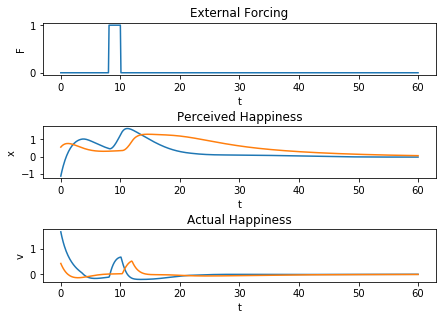

In [262]:
fig, axes = plt.subplots(3, 1)
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=3.0)

axes[0].plot(t, [F(ti) for ti in t])
axes[0].set_title('External Forcing')
axes[0].set_ylabel('F')
axes[0].set_xlabel('t')

axes[1].plot(t, np.array(y)[:,:N])
axes[1].set_title('Perceived Happiness')
axes[1].set_ylabel('x')
axes[1].set_xlabel('t')

axes[2].plot(t, np.array(y)[:,N:])
axes[2].set_title('Actual Happiness')
axes[2].set_ylabel('v')
axes[2].set_xlabel('t')
    
    

In [263]:
a

array([-0.10787338,  0.98454291])

In [264]:
b

array([-0.96410708,  0.93019138])

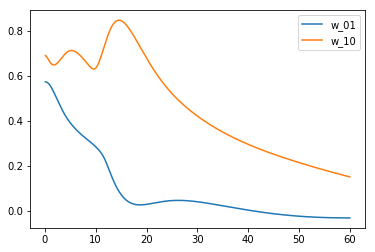

In [265]:
for i in range(N):
    for j in range(N):
        if i != j:
            plt.plot(t[1:], np.array(WIJ)[:, i, j], label = 'w_%s%s' %(i, j))
plt.legend()